In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('dark' + 'grid')
sns.set_palette('muted')
survival_palette={'Survived':'mediumaquamarine', 'Not survived':'lightcoral'}
# Gender colors will be the default muted blue and orange for males and females, respectively
# Other colors will be assigned as necessary
# Source for colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html

## 1.0 Importing Data

Import training data, and perform a quick overview of available data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


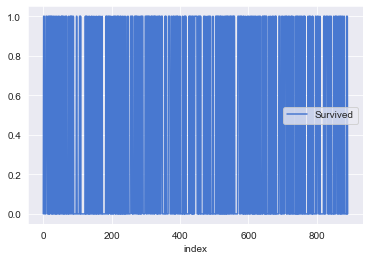

In [2]:
df = pd.read_csv('train.csv')
df.info()
df.reset_index().plot(x='index', y='Survived')

In [4]:
# General statistical information about the dataset
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Analyze missing values, which will be remediated at a later time. 

Cabin has many missing values (77%), will consider dropping if no relationships found with other variables. 

Possibly fill missing values of age with mean?

Embarked only has two missing values, can fill with most common value.

In [3]:
total = df.isnull().sum().sort_values(ascending=False)
percent = total/len(df) * 100
percent = round(percent, 2)
missing_data = pd.concat([total, percent], axis = 1, keys=['Total', '%'])
missing_data.head()

,Total,%
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
Fare,0,0.00
Ticket,0,0.00


### 1.1 Added columns

Below are columns we've added to the dataset throughout our analysis. We've put them into one spot for convenience.

In [3]:
#Uncomment as necessary
df['Sex_num'] = df['Sex'].map({'female': 0, 'male': 1})
df['Relatives'] = df['SibSp'] + df['Parch']
def extract_name(name):
    titles = ['Mr.', 'Don', 'Dr.', 'Rev', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer', 'Mrs.', 'Ms.', 'Mme', 'Lady', 'Mlle', 'Countess', 'Dona', 'Miss', 'Master']
    for title in titles:
        if title in name:
            return title
df['Title'] = df.apply(lambda row: extract_name(row['Name']), axis=1)
df['Target_name'] = df['Survived'].map({0: 'Not survived', 1: 'Survived'})

## 2.0 Data Exploration

 - Numerical data: 
    - Continuous: Age, Fare
    - Discrete: Sibsp, Parch
 - Categorical data:
    - Ordinal (order matters): Pclass
    - Nominal: Sex, Survived, Cabin, Embarked

Used a heatmap to assess any preliminary relationships between the data. Note, Pearson Correlation is typically for used for continuous data and categorical data with only two variables (i.e. survived and gender). For ordinal data, Spearman Correlation is recommended, however in this case they give very similar results since our ordinal data already has a numerical transformation. Took out Sibsp and Parch because they are not continuous or ordinal.

**Observations**

We observe a strong relationship between Gender and Survivived (females survived more), and medium inverse relationship between Pclass and Survived (lower Pclass survived more).

Also, medium relationship between Fare and Pclass, as expected, and with age and Pclass.

Resource for Pearson correlation: https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php

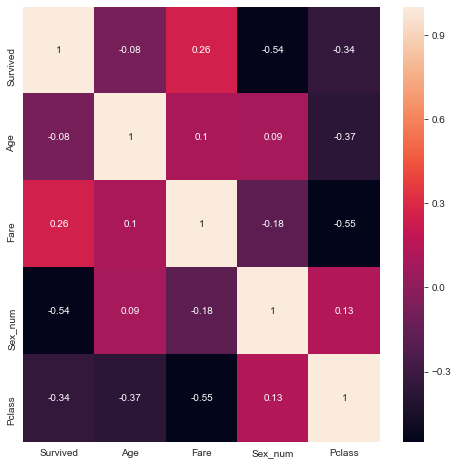

In [9]:
df['Sex_num'] = df['Sex'].map({'female': 0, 'male': 1})
cor_matrix = df[['Survived', 'Age', 'Fare', 'Sex_num', 'Pclass']].corr(method='pearson').round(2)
plt.figure(figsize=(8,8))
sns.heatmap(cor_matrix,annot=True);

## 2.1 Total Survival Rate

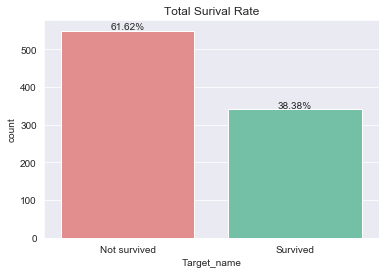

In [7]:
df['Target_name'] = df['Survived'].map({0: 'Not survived', 1: 'Survived'})
ax = sns.countplot(x='Target_name', data=df, palette=survival_palette)
ratio = df[df.Survived==1].shape[0]/df.shape[0]
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height() + 3,
            '{:1.2f}%'.format(p.get_height()/len(df)*100), ha="center") 
ax.set_title("Total Surival Rate");

## 2.2 Age

Mostly middle aged adults, very few senior citizens.

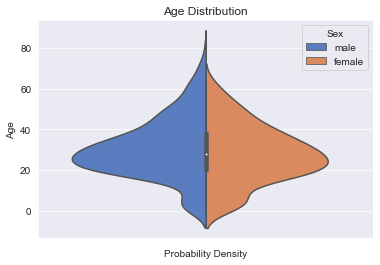

In [8]:
# Common column required for split violin plot to work (not sure if this is a bug?), dropped after use
df['All'] = ""
ax = sns.violinplot(y='Age', x='All', hue='Sex', data=df, split=True);
ax.set_title('Age Distribution');
ax.set_xlabel('Probability Density')
df.drop('All', axis=1, inplace=True)

Median and mean age for those who survivors and non-survivors are both very similar. **Age by *itself* does not seem to be a critical feature.**

Median age of survivors and non-survivors: 28.0, 28.0
Average age of survivors and non-survivors: 28.34, 30.63


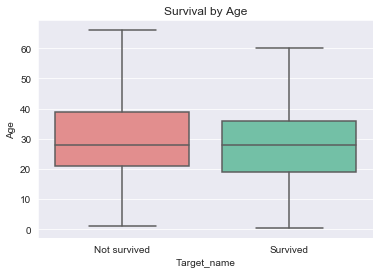

In [9]:
ax = sns.boxplot(y='Age', x='Target_name', data=df, showfliers = False, palette=survival_palette);
ax.set_title('Survival by Age')
print(f"Median age of survivors and non-survivors: {df[df.Survived==1].Age.median()}, {df[df.Survived==0].Age.median()}")
print(f"Average age of survivors and non-survivors: {df[df.Survived==1].Age.mean():.2f}, {df[df.Survived==0].Age.mean():.2f}")

## 2.3 Gender

Woman showed a much higher survival rate (74.20%) than men (18.89%).

In [10]:
print("74% of females survived versus only 19% of males.")
df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

74% of females survived versus only 19% of males.


,Sex,Survived
0,female,0.742038
1,male,0.188908


In [11]:
women = df[df.Sex=='female']
men = df[df.Sex=='male']
print(f"The number of females was {women.shape[0]} and number of males was {men.shape[0]}.")

The number of females was 314 and number of males was 577.


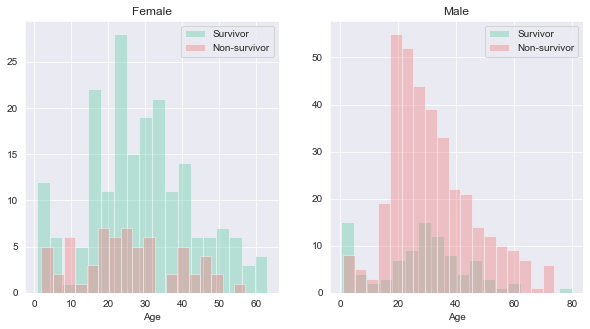

In [12]:
# Middle aged men were more likely to not survive
fig, axes = plt.subplots(1,2,figsize=(10,5))

ax = sns.distplot(women[women.Survived==1].Age.dropna(), kde=False, ax=axes[0], label='Survivor', bins=18, color='mediumaquamarine')
ax = sns.distplot(women[women.Survived==0].Age.dropna(), kde=False, ax=axes[0], label='Non-survivor', bins=18,color='lightcoral')
ax.set_title('Female')
ax.legend()

ax = sns.distplot(men[men.Survived==1].Age.dropna(), kde=False, ax=axes[1], label='Survivor', bins=18, color='mediumaquamarine')
ax = sns.distplot(men[men.Survived==0].Age.dropna(), kde=False, ax=axes[1], label='Non-survivor', bins=18, color='lightcoral')
ax.set_title('Male')
ax.legend();


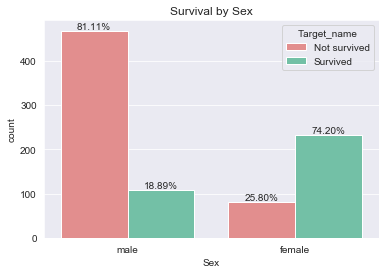

In [13]:
ax = sns.countplot(x='Sex', hue="Target_name", data=df, palette=survival_palette);
total = [len(df[df.Sex==i]) for i in df.Sex.sort_values(ascending=False).unique()] * 2
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height() + 3,
            '{:1.2f}%'.format(p.get_height()/total[i]*100), ha="center") 
ax.set_title("Survival by Sex");

## 2.4 Pclass

Those in the Pclass 3 (the lowest tier class) showed the lowest survival rate (24.2%).

In [14]:
df[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


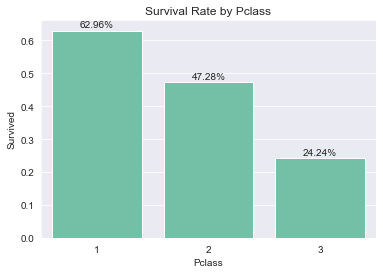

In [15]:
# Plotting above numbers
ax = sns.barplot(x='Pclass', y='Survived', data=df, color='mediumaquamarine', ci=None);
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height()+0.01,
            '{:1.2f}%'.format(p.get_height()*100), ha="center") 
ax.set_title('Survival Rate by Pclass');

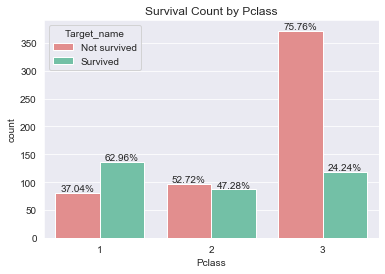

In [16]:
ax = sns.countplot(x='Pclass', hue="Target_name", data=df, palette=survival_palette);
total = [len(df[df.Pclass==i]) for i in df.Pclass.sort_values(ascending=True).unique()] * 2
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height() + 3,
            '{:1.2f}%'.format(p.get_height()/total[i]*100), ha="center") 
ax.set_title("Survival Count by Pclass");

As expected, Pclass 3 had mostly males, and thus aligns with the survivor rate we saw in gender.

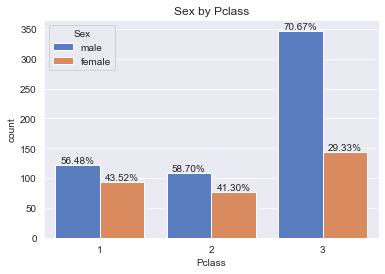

In [17]:

ax = sns.countplot(x='Pclass', hue="Sex", data=df);
total = [len(df[df.Pclass==i]) for i in df.Pclass.sort_values(ascending=True).unique()] * 2
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height() + 3,
            '{:1.2f}%'.format(p.get_height()/total[i]*100), ha="center") 
ax.set_title("Sex by Pclass");

## 2.5 Fare

We know that Fare and Pclass have some relationship, and it's confirmed by the plot below. As we would expect, those in the highest tier class (Pclass=1), were paying substantially higher fares.

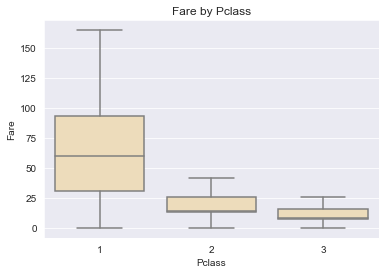

In [18]:
ax = sns.boxplot(y='Fare', x='Pclass', data=df, showfliers=False, color='wheat');
ax.set_title('Fare by Pclass');

Again, those that survived where paying on average higher fares.

Average fare of survivors was 48.40, and non-survivors was 22.12.


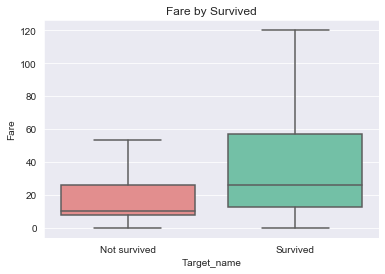

In [19]:
ax = sns.boxplot(y='Fare', x='Target_name', data=df, showfliers=False, palette=survival_palette);
ax.set_title('Fare by Survived');
print(f"Average fare of survivors was {df[df.Survived==1].Fare.mean():.2f}, and non-survivors was {df[df.Survived==0].Fare.mean():.2f}.")

Passengers between the ages of 10 to 30, and 70 to 80 paid the least for their fares.

Note that any fares above $200 are not shown.

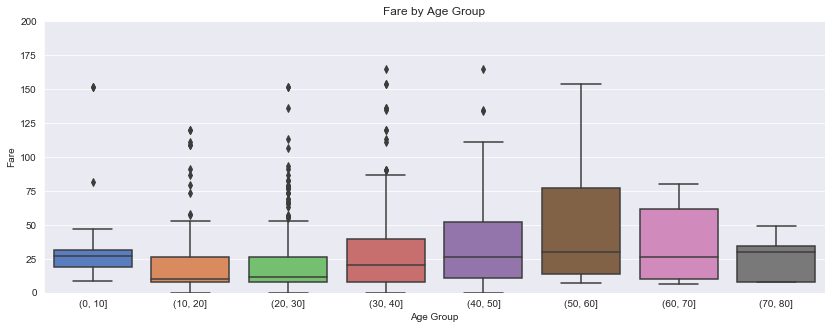

In [20]:
plt.figure(figsize=(14,5))
df['age_group'] = pd.cut(df['Age'], bins=range(0, 81, 10))
ax = sns.boxplot(x="age_group", y="Fare", data=df)
ax.set_title('Fare by Age Group');
ax.set_xlabel('Age Group');
ax.set(ylim=(0,200));

## 2.6 Embarked

Three possible embarking locations, with a majority embarking from port 'S'. 

Location 'S' also had the highest number of Pclass 3 passengers, and therefore we'd expect the lowest likelihood of survival from that port. 

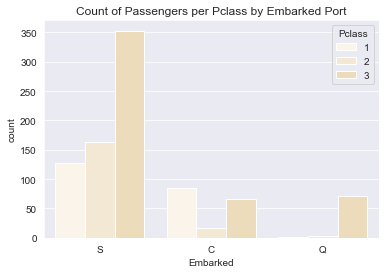

In [21]:
ax = sns.countplot(x='Embarked', hue='Pclass', data=df, color='wheat')
ax.set_title('Count of Passengers per Pclass by Embarked Port');

As expected, passengers who embarked at port 'S' had the lowest likelihood of survival. Port 'C' had the highest survival rate, due to most passengers being in Pclass 1. **Seems to be a correlation mostly between Pclass and Survival rather than Embark with Survival directly**.

**Note**: A line plot may not be the best way to show this because Embarked is not continuous data, other options?

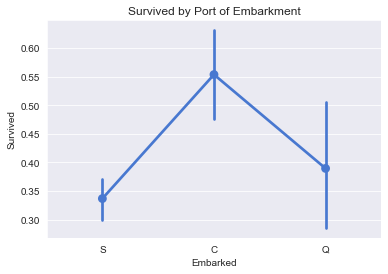

In [22]:
ax = sns.pointplot(x='Embarked', y='Survived', data=df)
ax.set_title("Survived by Port of Embarkment");

## 2.7 Sibsp and Parch

Number of siblings and parents/children on board can logically be combined together into a single field representing the number of relatives.

Credit to here for the idea: https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8

In [5]:
df['Relatives'] = df['SibSp'] + df['Parch']
df[['SibSp', 'Parch', 'Relatives']].head()

,SibSp,Parch,Relatives
0,1,0,1
1,1,0,1
2,0,0,0
3,1,0,1
4,0,0,0


We notice a substantial dip in likelihood of survival after a number of relatives of 3 (with the exception of 6).

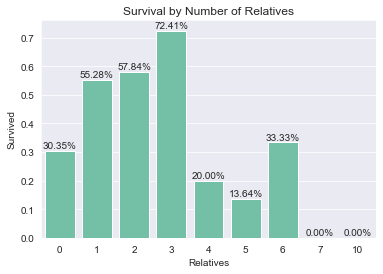

In [24]:
ax = sns.barplot(x='Relatives', y='Survived', data=df, color='mediumaquamarine', ci=None);
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height()+0.01,
            '{:1.2f}%'.format(p.get_height()*100), ha="center") 
ax.set_title("Survival by Number of Relatives");

## 2.8 Passenger Title

Each passenger name given in the dataset has an associated title.

The title appears to correlate to the age of the passenger in some cases (e.g. Master, Major, Reverend, etc).

In [10]:
# Extract the title for each person from the name attribute.
df["Title"] = ""

def extract_name(name):
    titles = ['Mr.', 'Don', 'Dr.', 'Rev', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer', 'Mrs.', 'Ms.', 'Mme', 'Lady', 'Mlle', 'Countess', 'Dona', 'Miss', 'Master']
    for title in titles:
        if title in name:
            return title

df['Title'] = df.apply(lambda row: extract_name(row['Name']), axis=1)

As seen in the plot below, by far the most occuring titles are Mr., Mrs., Miss and Master. Consider grouping the rest into an "Other" category?

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_num,Relatives,Title,Target_name
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C,1,1,Sir,Survived


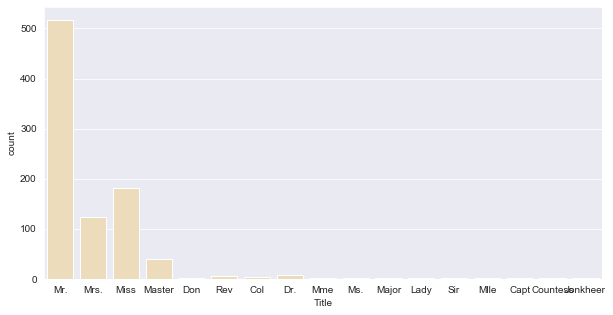

In [15]:
fig, ax =plt.subplots(figsize=(10,5))
ax = sns.countplot(x='Title', data=df, color='wheat')

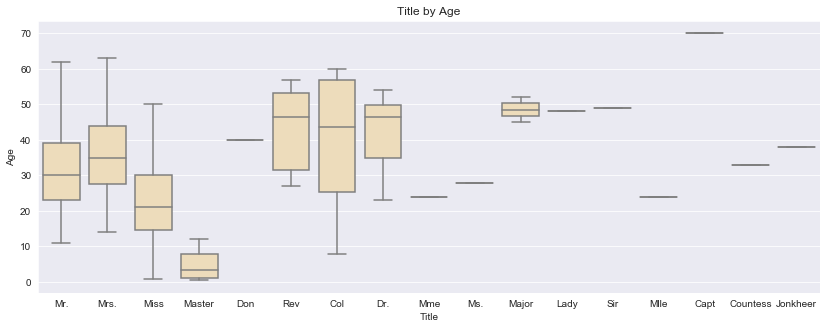

In [26]:
# Plot the passenger's title vs age
plt.figure(figsize=(14,5))
ax = sns.boxplot(y='Age', x='Title', data=df, showfliers = False, color='wheat');
ax.set_title('Title by Age');

As expected, the older male passengers with titles such as Mr., Don., Rev., etc had a much lower survival rate than those with female titles (Mrs., Miss, etc).

Men with titles associated with religion had a 0.0% survival rate, while men with a military title had a greater chance of survival versus other adult males.

Women with a title of Miss were found to have a lower survival rate than those with Mrs., although that could be associated with the class of the passenger.

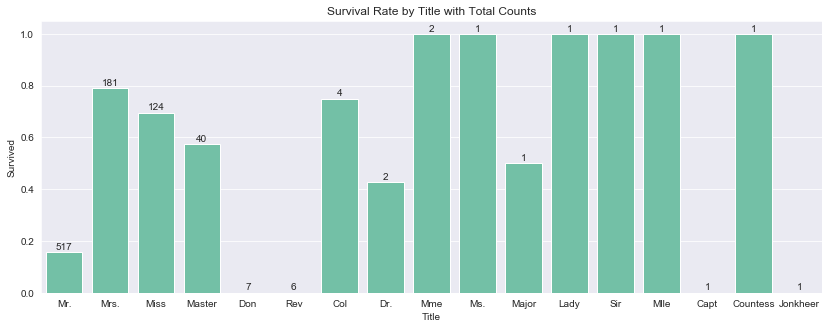

In [27]:
# Plot the passenger's title vs survival rate
plt.figure(figsize=(14,5))
ax = sns.barplot(x='Title', y='Survived', data=df, color='mediumaquamarine', ci=None);
for i, p in enumerate(ax.patches):
    ax.text(p.get_x()+p.get_width()/2, p.get_height()+0.01,
            df['Title'].value_counts()[i], ha="center") 
ax.set_title('Survival Rate by Title with Total Counts');

While most titles are gender-specific, both Dr. and Col. are not.

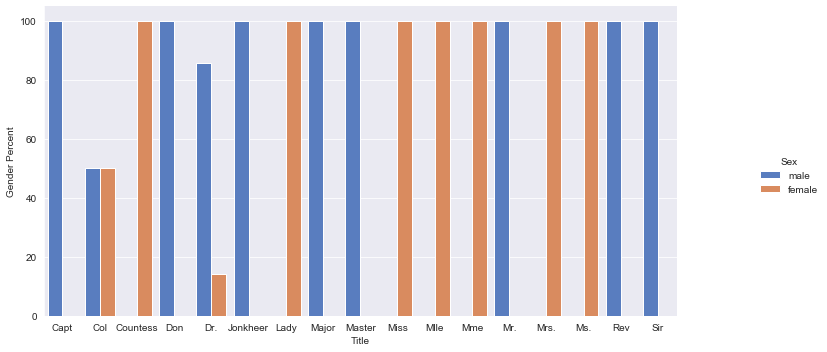

In [28]:
# Plot the passenger's title vs gender
x,y = 'Title', 'Sex'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Gender Percent').reset_index()

g = sns.catplot(x=x,y='Gender Percent',hue=y,kind='bar',data=df1)
g.fig.set_size_inches(12.5,5)

Those in the third class consisted only of passengers with the titles of "Master", "Miss", "Mr.", and "Mrs."

Those with the titles associated with either youth ("Master", or "Miss"), or non-professional men ("Mr.") were most likely to be found in third class.

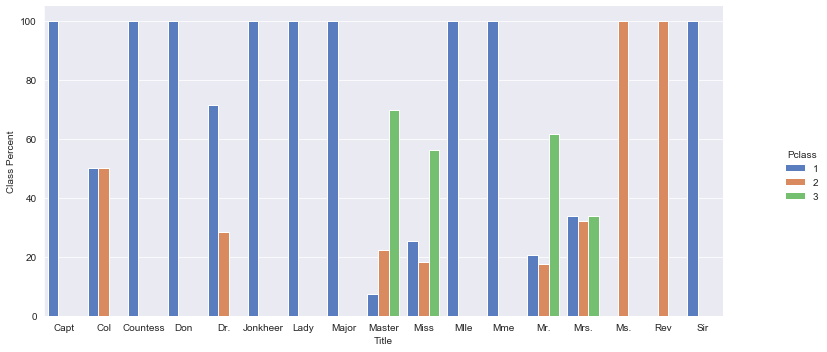

In [10]:
# Plot the passenger's title vs class
x,y = 'Title', 'Pclass'

df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Class Percent').reset_index()

g = sns.catplot(x=x,y='Class Percent',hue=y,kind='bar',data=df1)
g.fig.set_size_inches(12.5,5)

Non-professional men with the title of "Mr." were most likely to pay the least amount for the fare.

Ladies with the title "Miss" typically paid less than those with the title of "Mrs.", corresponding to the fact that those with "Miss" as a title were younger.

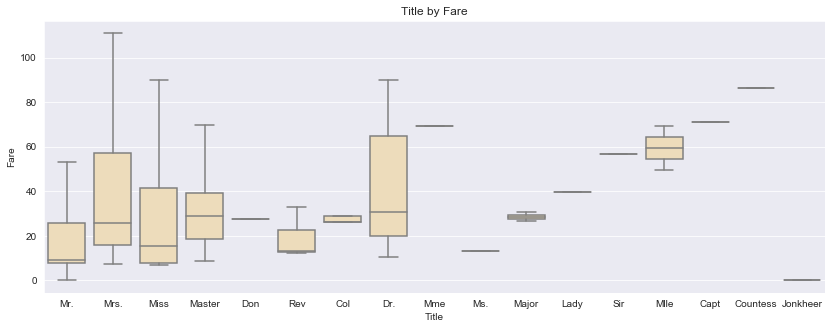

In [30]:
# Plot the passenger's title vs fare
plt.figure(figsize=(14,5))
ax = sns.boxplot(y='Fare', x='Title', data=df, showfliers = False, color='wheat');
ax.set_title('Title by Fare');

## 3.0 Data Pre-processing

Convert string fields to numeric and handle any trivial missing values.

Nominal non-binary categorical data (e.g. Embarked and Titles) will require one hot encoding to prevent misinterpretation by the model as ordered data. We will use pndas built in functionality to accomplish this.

In [4]:
# Age missing values
df[df.Age.isnull()]['Title'].count()

array(['Mr.', 'Mrs.', 'Miss', 'Master', 'Dr.'], dtype=object)

In [18]:
# Fill age with the mean values of their respective Pclass, Sex and Title
grouped_median_age = df.groupby(['Pclass', 'Sex','Title'])['Age'].median()
# Reset index to convert back to a regular dataframe
grouped_median_age = grouped_mean_age.reset_index()
grouped_median_age.head(10)

,index,Pclass,Sex,Title,Age
0,0,1,female,Countess,33.0
1,1,1,female,Dr.,49.0
2,2,1,female,Lady,48.0
3,3,1,female,Miss,30.0
4,4,1,female,Mlle,24.0
5,5,1,female,Mme,24.0
6,6,1,female,Mrs.,41.5
7,7,1,male,Capt,70.0
8,8,1,male,Col,58.0
9,9,1,male,Don,40.0


In [20]:
# Function to fill empty ages:
def fill_age(row):
    condition = ((grouped_median_age['Pclass']==row['Pclass']) & (grouped_median_age['Sex']==row['Sex']) & (grouped_median_age['Title']==row['Title']))
    if len(grouped_median_age[condition]['Age'])==0:
        print('Match not found, generalizing condition')
        condition = ((grouped_median_age['Pclass']==row['Pclass']) & (grouped_median_age['Sex']==row['Sex']))
    return round(grouped_median_age[condition]['Age'].values[0], 1)

df_processed = df.copy()
df_processed['Age'] = df_processed.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)


In [21]:
# Fill 2 missing values of embarked with most common value of 'S'
df_processed.Embarked.fillna(df_processed.Embarked.describe().top, inplace=True)

In [22]:
# Encode remaining non-numerical fields
# df['Embarked_num'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
df_processed = pd.concat([df_processed, pd.get_dummies(df_processed['Embarked'], prefix='Embarked')], axis=1)
df_processed.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_num,Relatives,Title,Target_name,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1,Mr.,Not survived,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,Mrs.,Survived,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,Miss,Survived,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1,Mrs.,Survived,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,Mr.,Not survived,0,0,1


In [23]:
# Use titles because it includes titles in both training and test datasets
df_processed = pd.concat([df_processed, pd.get_dummies(df_processed['Title'], prefix='Title')], axis=1)
df_processed.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr.,Title_Mrs.,Title_Ms.,Title_Rev,Title_Sir
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,1,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,1,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,1,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,1,0,0,0,0


In [24]:
# For now drop rows with empty age values
# Drop non-numerical and irrelevant rows
df_processed.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Target_name'], axis=1, inplace=True)
df_processed.shape

(891, 28)

In [25]:
# Set feature and label vectors
X = df_processed.drop(['Survived'], axis=1)
y = df_processed['Survived']
# # Title 'Dona' was missing from training data, therefore we add a column of zeros to X
# X['Title_Dona'] = 0

In [26]:
# # Split into train and test (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.0 Machine Learning

Perform grid search on multiple classifiers and find the best performing one.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score # if we end up using f1 score
from time import time
np.random.seed(42)

classifiers = ['Logistic Regression', 'KNN', 'SVC', 'Decision Tree', 'Random Forest']


In [29]:
# 10 folds is recommended for an initial starting point for CV
rows_list = []
for classifier in classifiers:
    print(classifier)
    if classifier == 'Logistic Regression':
        clf = LogisticRegression()
        parameters = {'penalty':['l1', 'l2'], 'C': [0.001, 0.1, 1, 10, 100]}
    elif classifier == 'KNN':
        clf = KNeighborsClassifier(n_neighbors=5)
        parameters = {'n_neighbors':[3, 5, 10], 'weights': ['uniform', 'distance']}
    elif classifier == 'SVC':
        # Note training time for linear was quite high so removed
        clf = SVC()
        parameters = {'kernel':['rbf'], 'C':[0.1, 1, 10, 100, 1000], 'gamma': ['auto']}
    elif classifier == "Decision Tree":
        clf = tree.DecisionTreeClassifier()
        parameters = {'min_samples_leaf':[1, 5, 10, 25], 'min_samples_split': [2, 4, 10, 12, 16, 18, 25, 35]}
    elif classifier == "Random Forest":
        clf = RandomForestClassifier()
        parameters = {'min_samples_leaf':[1, 5, 10, 25], 'min_samples_split': [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 200, 300]}
    # Train
    start_time = time()
    grid_search = GridSearchCV(clf, param_grid=parameters, cv=10)
    grid_search.fit(X_train, y_train)
    end_time = time()
    training_time = end_time-start_time
    # Test
    start_time = time()
    testing_score = grid_search.score(X_test, y_test)
    end_time = time()
    testing_time = end_time-start_time
    d = {'Classifier': classifier, 'Training_score': round(grid_search.best_score_, 3), 'Testing_score': round(testing_score, 3), 'Training_time': round(training_time, 2), 'Testing_time': round(testing_time, 2)}
    d.update(grid_search.best_params_)
    rows_list.append(d)

Logistic Regression
C:\Users\arsal\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
KNN
C:\Users\arsal\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
SVC
C:\Users\arsal\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
Decision Tree
Random Forest
C:\Users\arsal\Anaconda3\lib\site-pack

In [30]:
results = pd.DataFrame(rows_list).sort_values(['Training_score', 'Testing_score'], ascending=False).reset_index(drop=True)
results.head(10)

,Classifier,Training_score,Testing_score,Training_time,Testing_time,C,penalty,n_neighbors,weights,gamma,kernel,min_samples_leaf,min_samples_split,n_estimators
0,Random Forest,0.838,0.827,353.15,0.07,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18.0,300.0
1,Logistic Regression,0.831,0.810,5.01,0.00,1.0,l1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Decision Tree,0.809,0.838,4.02,0.00,NaN,NaN,NaN,NaN,NaN,NaN,10.0,35.0,NaN
3,SVC,0.746,0.754,6.23,0.01,10.0,NaN,NaN,NaN,auto,rbf,NaN,NaN,NaN
4,KNN,0.723,0.709,1.09,0.01,NaN,NaN,3.0,distance,NaN,NaN,NaN,NaN,NaN


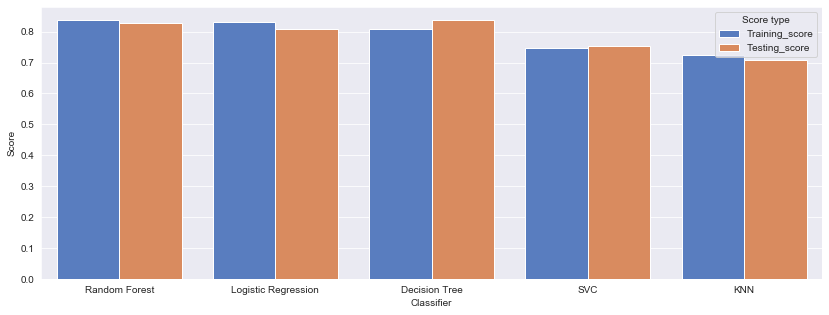

In [50]:
results_melt = results.melt(['Classifier'], var_name='Score type', value_vars=['Training_score', 'Testing_score'], value_name='Score')
fig, ax = plt.subplots(figsize=(14,5))
ax = sns.barplot(x='Classifier', y='Score', data=results_melt, hue='Score type')
# ax = sns.barplot(x='Classifier', y='Testing_score', data=results, color='mediumaquamarine')
# ax.set_ylim(0.5)
# ax.set_title('Training Scores - No Age');
# ax.tick_params(axis='x', labelsize=8.5)

## 5.0 Applying to Test data

In [61]:
test_df = pd.read_csv('test.csv')
test_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [62]:
total = test_df.isnull().sum().sort_values(ascending=False)
total.head()

Cabin       327
Age          86
Fare          1
Embarked      0
Ticket        0
dtype: int64

In [63]:
# Fill empty fare value with average of its Pclass
test_df.Fare.fillna(test_df[test_df.Pclass==3]['Fare'].mean(), inplace=True)

In [64]:
total = test_df.isnull().sum().sort_values(ascending=False)
total.head()

Cabin       327
Age          86
Embarked      0
Fare          0
Ticket        0
dtype: int64

In [65]:
test_df['Sex_num'] = test_df['Sex'].map({'female': 0, 'male': 1})
test_df['Relatives'] = test_df['SibSp'] + df['Parch']
def extract_name(name):
    titles = ['Mr.', 'Don', 'Dr.', 'Rev', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer', 'Mrs.', 'Ms.', 'Mme', 'Lady', 'Mlle', 'Dona', 'Countess', 'Miss', 'Master']
    for title in titles:
        if title in name:
            return title
test_df['Title'] = test_df.apply(lambda row: extract_name(row['Name']), axis=1)

In [66]:
# Fill age with the mean values of their respective Pclass, Sex and Title
test_grouped_median_age = test_df.groupby(['Pclass', 'Sex','Title'])['Age'].median()
# Reset index to convert back to a regular dataframe
test_grouped_median_age = grouped_mean_age.reset_index()
test_grouped_median_age.head()

,index,Pclass,Sex,Title,Age
0,0,1,female,Countess,33.0
1,1,1,female,Dr.,49.0
2,2,1,female,Lady,48.0
3,3,1,female,Miss,30.0
4,4,1,female,Mlle,24.0


In [67]:
def fill_age(row):
    condition = ((test_grouped_median_age['Pclass']==row['Pclass']) & (test_grouped_median_age['Sex']==row['Sex']) & (test_grouped_median_age['Title']==row['Title']))
    if len(test_grouped_median_age[condition]['Age'])==0:
        print('Match not found, generalizing condition')
        condition = ((test_grouped_median_age['Pclass']==row['Pclass']) & (test_grouped_median_age['Sex']==row['Sex']))
    return round(test_grouped_median_age[condition]['Age'].values[0], 1)

test_df_processed = test_df.copy()
test_df_processed['Age'] = test_df_processed.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)

Match not found, generalizing condition


In [68]:
# Ensure all titles included even if not in test dataset
test_df_processed = pd.concat([test_df_processed, pd.get_dummies(test_df_processed['Title'], prefix='Title')], axis=1)
test_df_processed = pd.concat([test_df_processed, pd.get_dummies(test_df_processed['Embarked'], prefix='Embarked')], axis=1)
test_df_processed.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Title_Don,Title_Dr.,Title_Master,Title_Miss,Title_Mr.,Title_Mrs.,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,0,0,0,0,1,0,0,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,0,0,0,0,0,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,0,0,0,0,1,0,0,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,0,0,0,0,1,0,0,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,0,0,0,0,0,1,0,0,0,1


In [69]:
# Drop non-numerical and irrelevant rows
test_df_processed.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title'], axis=1, inplace=True)
test_df_processed.shape

(418, 18)

In [72]:
# Make sure all columns that are in train dataset are in the test as well
missing_columns = df_processed.columns.difference(test_df_processed.columns)
# Add missing columns to test_processed
for column in missing_columns:
    if column != 'Survived':
        test_df_processed[column] = 0

In [74]:
# Feature vector for test data
X_test = test_df_processed
X_test.shape

(418, 27)

In [75]:
# Random forest
test_df = pd.read_csv('test.csv')
clf = RandomForestClassifier(min_samples_leaf=1, min_samples_split=18, n_estimators=300)
clf.fit(X, y)
print("The score on the training data:", clf.score(X, y))
y_pred = clf.predict(X_test)
rf_result = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': y_pred})
rf_result.to_csv('rf_result_with_age.csv', index=False)

The score on the training data: 0.8720538720538721


In [77]:
# Logistic regression
clf = LogisticRegression(penalty='l1',C=1.0)
clf.fit(X, y)
print("The score on the training data:", clf.score(X, y))
y_pred = clf.predict(X_test)
lr_result = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': y_pred})
lr_result.to_csv('lr_result_with_age.csv', index=False)

The score on the training data: 0.8327721661054994


In [32]:
# Decision tree
clf = tree.DecisionTreeClassifier(min_samples_leaf=1, min_samples_split=25)
clf.fit(X, y)
print("The score on the training data:", clf.score(X, y))
y_pred = clf.predict(X_test)
lr_result = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': y_pred})
lr_result.to_csv('dt_result_no_age.csv', index=False)

The score on the training data: 0.8754208754208754


## XX Handling Missing Values

From our data exploration, we found that cabin and age had the most missing values. With almost 77%, it seems unfeasible to include cabin as a feature. With embarked, since there are only 2 missing values, we can confidently fill them with the most common value (by far) of "S". Finally, for age we can be a bit more creative, and attempt to predict the missing values rather than simply filling in with mode, median or mean.

In [35]:

# To maximize the data available to us for prediction, will use the test data as well
df_test = pd.read_csv('test.csv')
# Start with a fresh training dataframe as well
df_train = pd.read_csv('train.csv')

print(f"The amount of missing age values in the test datset is {df_test.Age.isnull().sum()}, or {df_test.Age.isnull().sum()/len(df_test.Age)*100:.2f}%.")

The amount of missing age values in the test datset is 86, or 20.57%.


In [49]:
df_combined = pd.concat([df_train, df_test], ignore_index=True)
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [52]:
# Adding the new features to the combined dataset and mapping some to numerical
df_combined['Title'] = df_combined.apply(lambda row: extract_name(row['Name']), axis=1)
df_combined['Sex_num'] = df_combined['Sex'].map({'female': 0, 'male': 1})
df_combined['Relatives'] = df_combined['SibSp'] + df_combined['Parch']

In [53]:
df_combined.tail(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Sex_num,Relatives
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mr.,1,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Don,0,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr.,1,0
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Mr.,1,0
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,Master,1,2


In [56]:
total = df_combined.isnull().sum().sort_values(ascending=False)
percent = total/len(df_combined) * 100
percent = round(percent, 2)
missing_data = pd.concat([total, percent], axis = 1, keys=['Total', '%'])
missing_data.head(10)

,Total,%
Cabin,1014,77.46
Survived,418,31.93
Age,263,20.09
Embarked,2,0.15
Fare,1,0.08
Relatives,0,0.00
Sex_num,0,0.00
Title,0,0.00
Ticket,0,0.00
Parch,0,0.00


In [60]:
# Fill empty embarked value with 'S'
df_combined.Embarked.fillna(df_combined.Embarked.describe().top, inplace=True)

In [57]:
# Collect the existing rows with filled age values
df_age_exists = df_combined[df_combined.Age.isnull() == False]
df_age_pred = 

In [58]:
len(df_age_exists)

1046

In [59]:
df_combined.Embarked.describe().top

'S'